<a href="https://colab.research.google.com/github/diputs03/AI-Studies/blob/main/Creating_network/rebuilt_again.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque

class GraphNetwork:
    class Neuron:
        def __init__(self, id, is_input=False, is_output=False):
            self.id = id
            self.in_edges = {}  # {source_neuron: weight}
            self.out_edges = {}
            self.bias = np.random.normal(0, 0.1)
            self.is_input = is_input
            self.is_output = is_output

        def add_connection(self, source, weight):
            self.in_edges[source] = weight
            source.out_edges[self] = weight

    def __init__(self, input_size, output_size):
        self.neurons = {}
        self.inputs = []
        self.outputs = []

        # Create input neurons
        for i in range(input_size):
            neuron = self.Neuron(f"input_{i}", is_input=True)
            self.neurons[neuron.id] = neuron
            self.inputs.append(neuron)

        # Create output neurons
        for o in range(output_size):
            neuron = self.Neuron(f"output_{o}", is_output=True)
            self.neurons[neuron.id] = neuron
            self.outputs.append(neuron)

        # Randomly connect inputs to outputs initially
        for input_neuron in self.inputs:
            for output_neuron in self.outputs:
                weight = np.random.normal(0, 0.1)
                output_neuron.add_connection(input_neuron, weight)

    def add_neuron(self, sources=None):
        """Dynamically add a new neuron to the graph"""
        new_id = f"hidden_{len(self.neurons) - len(self.inputs) - len(self.outputs)}"
        new_neuron = self.Neuron(new_id)

        if sources is None:
            # Randomly connect to existing neurons
            sources = random.sample(list(self.neurons.values()),
                                  k=min(3, len(self.neurons)))

        for source in sources:
            weight = np.random.normal(0, 0.1)
            new_neuron.add_connection(source, weight)

        self.neurons[new_neuron.id] = new_neuron
        return new_neuron

    def forward(self, X):
        # Initialize activations
        activations = {neuron: np.zeros(X.shape[0]) for neuron in self.neurons.values()}

        # Set input activations
        for i, neuron in enumerate(self.inputs):
            activations[neuron] = X[:, i]

        # Topological sort for forward pass
        visited = set()
        processing = deque()

        for neuron in self.inputs:
            processing.append(neuron)

        while processing:
            current = processing.popleft()

            if current in visited:
                continue

            visited.add(current)

            if current.is_input:
                # Already set inputs
                continue

            # Calculate activation
            z = current.bias
            for source, weight in current.in_edges.items():
                z += activations[source] * weight

            # Apply ReLU for hidden, softmax for output
            if current.is_output:
                # Will apply softmax later
                activations[current] = z
            else:
                activations[current] = np.maximum(0, z)

            # Add downstream neurons to processing
            for out_neuron in current.out_edges:
                if all(s in visited for s in out_neuron.in_edges):
                    processing.append(out_neuron)

        # Apply softmax to outputs
        output_acts = np.array([activations[o] for o in self.outputs]).T
        exp = np.exp(output_acts - np.max(output_acts, axis=1, keepdims=True))
        output_probs = exp / exp.sum(axis=1, keepdims=True)

        for i, o in enumerate(self.outputs):
            activations[o] = output_probs[:, i]

        return activations

    def backward(self, X, y, learning_rate=0.1):
        batch_size = X.shape[0]
        activations = self.forward(X)

        # Calculate gradients
        gradients = {n: np.zeros(batch_size) for n in self.neurons.values()}

        # Output gradients
        output_acts = np.array([activations[o] for o in self.outputs]).T
        output_grad = output_acts - y

        for i, o in enumerate(self.outputs):
            gradients[o] = output_grad[:, i]

        # Backward pass using reverse topological order
        processed = set()
        processing = deque(self.outputs)

        while processing:
            current = processing.popleft()

            if current in processed:
                continue

            processed.add(current)

            # Propagate gradient to inputs
            if not current.is_input:
                grad = gradients[current]

                if not current.is_output:
                    grad *= (activations[current] > 0).astype(float)  # ReLU derivative

                # Update bias
                current.bias -= learning_rate * np.mean(grad)

                # Update incoming weights and propagate gradients
                for source, weight in current.in_edges.items():
                    # Weight gradient
                    delta_w = np.dot(activations[source], grad) / batch_size
                    current.in_edges[source] -= learning_rate * delta_w

                    # Propagate gradient to source
                    gradients[source] += grad * weight

                    # Add source to processing if all downstreams processed
                    if all(n in processed for n in source.out_edges):
                        processing.append(source)

    def train(self, X, y, X_test, y_test, epochs=10, batch_size=128, dynamic_growth=True):
        for epoch in range(epochs):
            # Randomly add neurons during training
            if dynamic_growth and epoch % 2 == 0:
                self.add_neuron()

            permutation = np.random.permutation(len(X))
            for i in range(0, len(X), batch_size):
                batch_idx = permutation[i:i+batch_size]
                X_batch = X[batch_idx]
                y_batch = y[batch_idx]

                self.backward(X_batch, y_batch, learning_rate=0.01)

            # Calculate accuracy
            preds = np.argmax(self.predict(X_test), axis=1)
            acc = np.mean(preds == np.argmax(y_test, axis=1))
            print(f"Epoch {epoch+1}/{epochs} - Accuracy: {acc:.4f}")

    def predict(self, X):
        activations = self.forward(X)
        return np.array([activations[o] for o in self.outputs]).T

Epoch 1/2 - Accuracy: 0.0980
Epoch 2/2 - Accuracy: 0.0980


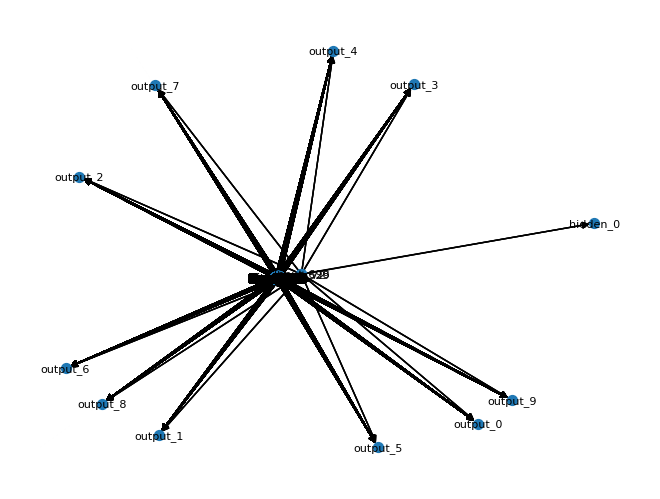

In [13]:

import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 784).astype('float32') / 255.0
x_test = x_test.reshape(-1, 784).astype('float32') / 255.0
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Example usage
model = GraphNetwork(784, 10)
model.train(x_train, y_train, x_test, y_test, epochs=2, batch_size=256)

# Visualize connections (requires networkx and matplotlib)
def visualize_graph(model):
    import networkx as nx

    G = nx.DiGraph()
    for neuron in model.neurons.values():
        G.add_node(neuron.id)
        for source in neuron.in_edges:
            G.add_edge(source.id, neuron.id)

    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=50, font_size=8)
    plt.show()

#visualize_graph(model)

In [21]:
import numpy as np
import random
from collections import defaultdict, deque

class DynamicGraphNetwork:
    class Neuron:
        __slots__ = ('id', 'in_edges', 'out_edges', 'bias', 'is_input', 'is_output')  # Memory optimization

        def __init__(self, neuron_id, is_input=False, is_output=False):
            self.id = neuron_id
            self.in_edges = {}  # {source: weight}
            self.out_edges = {}
            self.bias = np.random.normal(0, 0.01)  # Small initial bias
            self.is_input = is_input
            self.is_output = is_output

    def __init__(self, input_size, output_size):
        """Efficiency Constants:
        - INITIAL_HIDDEN: Balance between capacity and computation (↔ accuracy vs speed)
        - MAX_CONNECTIONS: Prevent exponential parameter growth (↔ memory vs expressivity)
        - GROWTH_INTERVAL: Trade-off between plasticity and stability (↔ learning speed vs convergence)
        """
        self.neurons = {}
        self.input_size = input_size
        self.output_size = output_size

        # Initialize network structure
        self.inputs = [self._add_neuron(f"input_{i}", is_input=True)
                      for i in range(input_size)]
        self.outputs = [self._add_neuron(f"output_{o}", is_output=True)
                       for o in range(output_size)]

        # Create initial hidden layer
        self._add_hidden_layer(INITIAL_HIDDEN=8)  # Start small, grow dynamically

        # Structural constraints
        self.MAX_CONNECTIONS = 5  # Prevent over-connection
        self.GROWTH_INTERVAL = 500  # Samples processed before adding neurons
        self.samples_seen = 0

    def _add_neuron(self, neuron_id, is_input=False, is_output=False):
        neuron = self.Neuron(neuron_id, is_input, is_output)
        self.neurons[neuron_id] = neuron
        return neuron

    def _connect_neurons(self, source, target, weight=None):
        """Efficient connection management with max connections enforcement"""
        if len(target.in_edges) >= self.MAX_CONNECTIONS:
            # Remove weakest existing connection
            min_source = min(target.in_edges, key=lambda k: abs(target.in_edges[k]))
            del target.in_edges[min_source]
            del min_source.out_edges[target]

        if weight is None:
            weight = np.random.normal(0, np.sqrt(2/(len(source.in_edges)+1)))  # He-like init
        target.in_edges[source] = weight
        source.out_edges[target] = weight

    def _add_hidden_layer(self, size):
        """Efficient layer addition with sparse connections"""
        new_neurons = [self._add_neuron(f"hidden_{len(self.neurons)}")
                      for _ in range(size)]

        # Connect to random existing neurons
        for neuron in new_neurons:
            sources = random.sample(list(self.neurons.values()),
                           k=min(3, len(self.neurons)))
            for src in sources:
                self._connect_neurons(src, neuron)

            # Connect to outputs
            for output in self.outputs:
                self._connect_neurons(neuron, output)

    def topological_order(self):
        """Kahn's algorithm for guaranteed valid processing order"""
        in_degree = {n: 0 for n in self.neurons.values()}
        for neuron in self.neurons.values():
            for successor in neuron.out_edges:
                in_degree[successor] += 1

        queue = deque([n for n in self.neurons.values() if in_degree[n] == 0])
        order = []

        while queue:
            node = queue.popleft()
            order.append(node)
            for successor in node.out_edges:
                in_degree[successor] -= 1
                if in_degree[successor] == 0:
                    queue.append(successor)

        if len(order) != len(self.neurons):
            raise ValueError("Graph contains cycles!")
        return order

    def forward(self, X):
        """Efficient forward pass with pre-allocated activation storage"""
        activations = defaultdict(lambda: np.zeros(X.shape[0]))

        # Set input activations
        for i, neuron in enumerate(self.inputs):
            activations[neuron] = X[:, i].copy()

        # Process in topological order
        for neuron in self.topological_order():
            if neuron.is_input:
                continue

            z = neuron.bias.copy()
            for src, weight in neuron.in_edges.items():
                z += activations[src] * weight

            # ReLU for hidden, linear for outputs
            activations[neuron] = z if neuron.is_output else np.maximum(0, z)

        # Collect outputs
        output = np.array([activations[o] for o in self.outputs]).T
        return output

    def backward(self, X, y, learning_rate=0.01, momentum=0.5):
        """Manual SGD with momentum for stability"""
        batch_size = X.shape[0]
        output = self.forward(X)

        # Softmax gradient
        exp = np.exp(output - np.max(output, axis=1, keepdims=True))
        probs = exp / exp.sum(axis=1, keepdims=True)
        output_grad = (probs - y) / batch_size  # Normalized gradient

        # Backward pass buffers
        gradients = defaultdict(lambda: np.zeros(batch_size))
        momentum_cache = defaultdict(float)

        # Initialize output gradients
        for i, o in enumerate(self.outputs):
            gradients[o] = output_grad[:, i]

        # Process in reverse topological order
        for neuron in reversed(self.topological_order()):
            if neuron.is_input:
                continue

            grad = gradients[neuron]

            # Update bias with momentum
            delta_b = np.mean(grad)
            neuron.bias -= learning_rate * (delta_b + momentum * momentum_cache[neuron])
            momentum_cache[neuron] = delta_b

            # Propagate to inputs
            for src in neuron.in_edges.copy():
                # Weight update
                delta_w = np.mean(activations[src] * grad)
                update = learning_rate * (delta_w + momentum * momentum_cache[(src, neuron)])
                neuron.in_edges[src] -= update
                momentum_cache[(src, neuron)] = delta_w

                # Gradient propagation
                gradients[src] += grad * neuron.in_edges[src]

                # Prune weak connections
                if abs(neuron.in_edges[src]) < 0.001:
                    del neuron.in_edges[src]
                    del src.out_edges[neuron]

    def train(self, X_train, y_train, X_test, y_test, epochs=20, batch_size=128):
        """Training loop with dynamic growth"""
        for epoch in range(epochs):
            permutation = np.random.permutation(len(X_train))
            for i in range(0, len(X_train), batch_size):
                batch_idx = permutation[i:i+batch_size]
                X_batch = X_train[batch_idx]
                y_batch = y_train[batch_idx]

                self.backward(X_batch, y_batch)

                # Dynamic growth condition
                self.samples_seen += batch_size
                if self.samples_seen >= self.GROWTH_INTERVAL:
                    self._add_hidden_layer(size=2)  # Small growth steps
                    self.samples_seen = 0

            # Validation
            test_pred = self.predict(X_test)
            acc = np.mean(np.argmax(test_pred, axis=1) == np.argmax(y_test, axis=1))
            print(f"Epoch {epoch+1}/{epochs} | Accuracy: {acc:.4f}")

    def predict(self, X):
        logits = self.forward(X)
        return softmax(logits)

def softmax(x):
    ex = np.exp(x - np.max(x, axis=1, keepdims=True))
    return ex / ex.sum(axis=1, keepdims=True)

# Usage example
if __name__ == "__main__":
    # Load data
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = x_train.reshape(-1, 784).astype('float32') / 255.0
    x_test = x_test.reshape(-1, 784).astype('float32') / 255.0
    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_test = tf.keras.utils.to_categorical(y_test, 10)

    # Initialize and train
    model = DynamicGraphNetwork(784, 10)
    model.train(x_train, y_train, x_test, y_test, epochs=20, batch_size=256)

AttributeError: 'DynamicGraphNetwork' object has no attribute 'MAX_CONNECTIONS'